# T5: Transfer Text-to-Text Transformer
(Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer)

## 概述：
* 本文引入一个统一的自然语言处理迁移框架，该框架将所有的自然言语处理任务统一为 text-to-text 形式，即：给整个 NLP 预训练模型领域提供了一个通用框架，把所有任务都转化成一种形式（introducing a unified framework that converts every language problem into a text-to-text format）    
  
    *Example：将任务要求写在开头，T5模型即可完成该 text-to-text任务  ：*

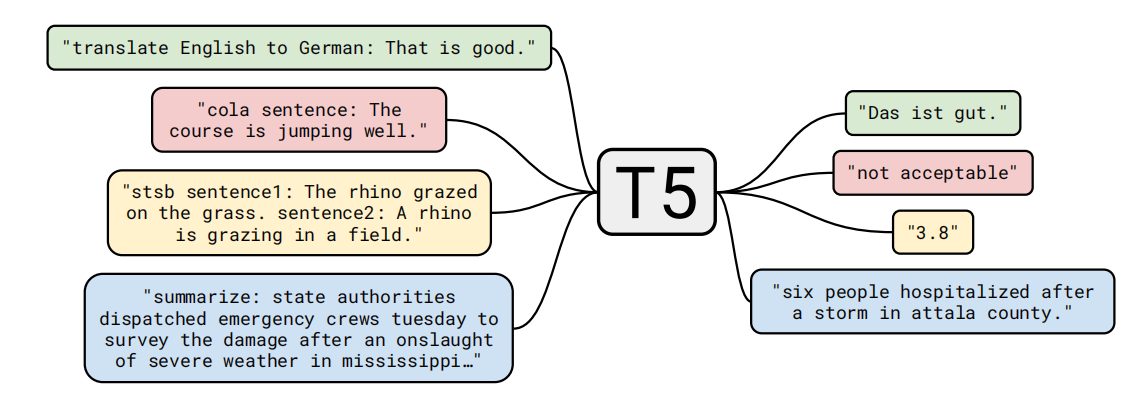

* 本文的贡献：并不是提出新的方法，而是提供一个全面的视野
  * 对现有技术的调查、探索和经验比较
  * 把每一个问题都当作一个text-to-text的任务  
  （原文introduction部分）

## 整合 & 择优：
### Mask方式：
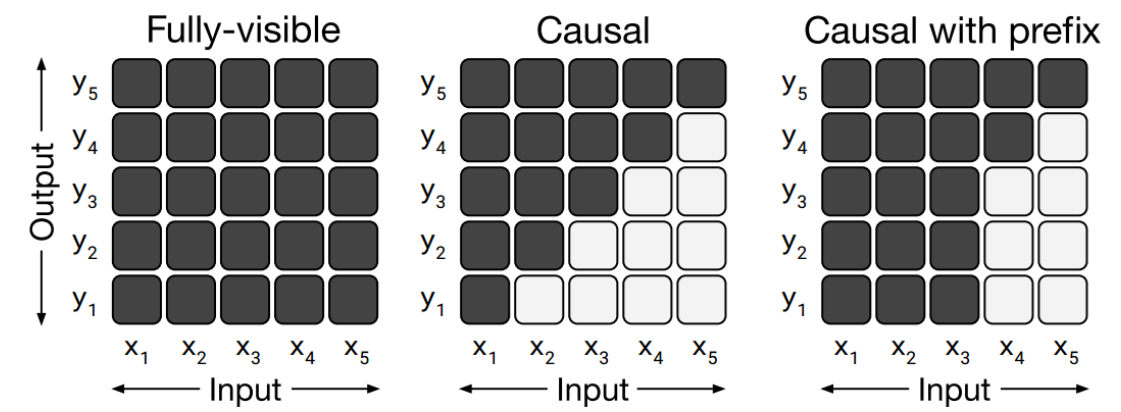    

解释：该图应该以坐标轴的方式来看：坐标为（i，j）的黑色块代表：在输出时间点i，自注意力机制允许j作为输入（A dark cell at row i and column j indicates that the self-attention mechanism is allowed to attend to input element j at output timestep i）
1. 全视野mask(fully-visible mask)：可见所有  
   
2. 因果mask(causal mask)：不可见未来的部分  
   
3. 带前缀的因果mask(causal masking with a prefix)  
   

### 模型架构：
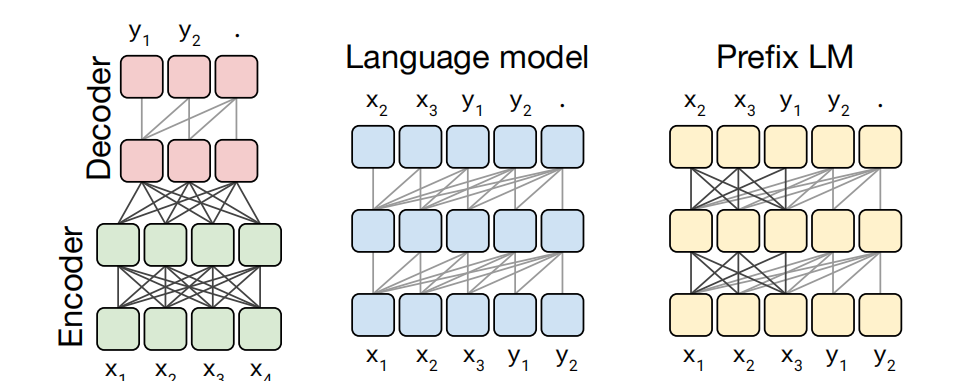    

解释：上面这些模型架构都是 Transformer 构成，之所以有这些变换，主要是对其中注意力机制的 Mask 操作，3种模型与3种mask从左到右对应
1. Encoder-Decoder 型，即 Seq2Seq 常用模型，分成 Encoder 和 Decoder 两部分，对于 Encoder 部分，输入可以看到全体，之后结果输给 Decoder，而 Decoder 因为输出方式只能看到之前的，代表：典型transformer  
   
2. 相当于上面的 Decoder 部分，当前时间步只能看到之前时间步信息，典型代表是 GPT2  
   
3. Prefix LM（Language Model） 型，可看作是上面 Encoder 和 Decoder 的融合体，一部分如 Encoder 一样能看到全体信息，一部分如 Decoder 一样只能看到过去信息。代表： UniLM   
  
            （选择：Encoder-Decoder结构）

### 高层次方法（自监督的预训练方法）High Level Approaches：
1. 语言模型式，就是 GPT-2 那种方式，从左到右预测；
2. BERT-style 式，就是像 BERT 一样将一部分给破坏掉，然后还原出来；
3. Deshuffling （顺序还原）式，就是将文本打乱，然后还原出来  

            （选择：Bert-style ）

### 对文本一部分进行破坏时的策略
1. Mask 法，将被破坏 token 换成特殊符如 [M]
2. 可以把它当作是把上面 Mask 法中相邻 [M] 都合成了一个特殊符，每一小段替换一个特殊符，提高计算效率
3. Drop 法，没有替换操作，直接随机丢弃一些字符  
            （选择：Replace Span）

### 文本破坏百分比：
10%，15%，25%，50%    

            （选择：15%，通bert）

### 文本破坏单元的长度：
2，3，5，10      

            （选择：3）
     
#### 图示：   

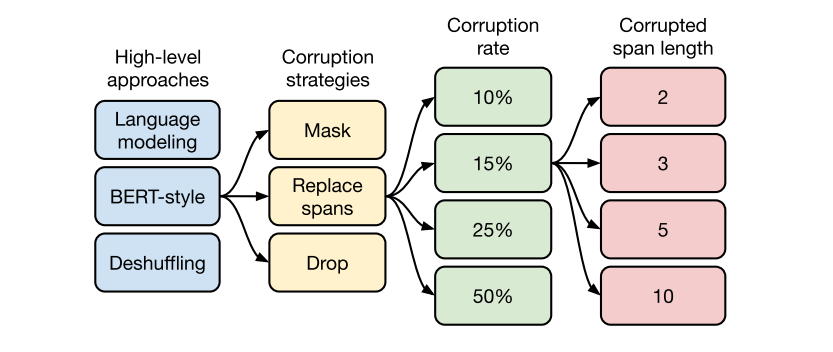

### 最终的T5模型 & 训练方法：
* Transformer Encoder-Decoder 模型；
  
* BERT-style 式的破坏方法；
  
* Replace Span 的破坏策略；
  
* 15 %的破坏比；
  
* 3 的破坏时小段长度。

### 训练策略
#### 微调策略：
1. adapter layers。在Transformer每个block中的前馈神经网络后添加dense-ReLU-dense blocks。新的前馈网络使得输出可以与输入维度匹配。微调阶段，只有adapter layer和layer normalization的参数被更新。这种方法的超参数是内部前馈网络的维度d。
2. gradual unfreezing。这种方式是更新模型参数的范围随着随着时间扩大。初始微调时，只有最后一层的参数被更新，训练一段时间后，倒数第2层及其之后层的参数被更新，直至整个网络的参数都被更新。
##### 实验结果
  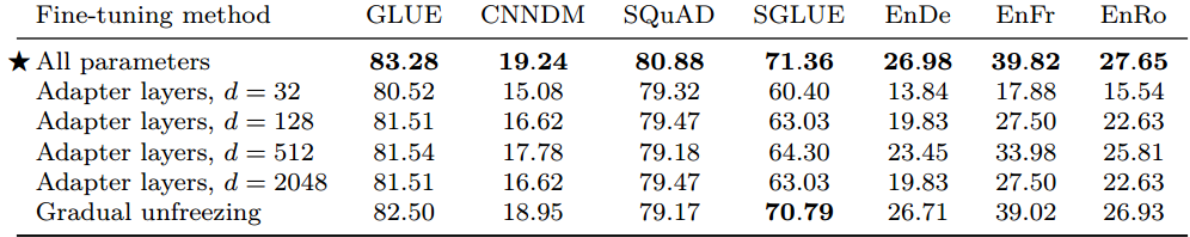

#### 多任务学习：
<style>
  p{
    line-height: 1.5
  }
</style>
<p>
多任务学习是同时在多个任务上训练一个模型，其目的是训练一个能同时处理多个任务的模型，即该模型中的绝大数参数在多个任务之间是共享的。本文对此目标稍稍宽松，转而研究对多个任务同时进行训练的方法，以便最终生成**对每个单独任务都表现良好的独立参数**。所以，本文这里是简化版的多任务学习，并不热衷于多任务之间的参数共享，而是更关注于用同一个时间训练多个任务。例如，我们或许可以在多个任务上训练一个模型，但是应用到具体任务时候，可以针对不同的任务选用不同的checkpoint。这就放宽了多任务学习框架，与当下我们所考虑的 预训练-微调 的方法 相比， 它的基础才显得牢固。还注意到，在本文统一的text-to-text框架中，“多任务学习”简单地对应于将数据集混合在一起。相比之下，此前NLP中的多任务学习大多数都是为每个任务添加特定的分类网络或使用不同的损失函数。
</p>

*每个任务需要用多少数据进行训练? 本文3种方案：*
1. Examples-proportional mixing
2. Temperature-scaled mixing 
3. Equal mixing

*缩小多任务训练和 预训练-微调 的差距, 3种方案：*
1. 先进行数据预训练，再对下游任务微调
2. 与1同，但在预训练混合的下游任务中丢弃一个任务
3. 对于全部的有监督任务的数据进行预训练


##### 实验结果：
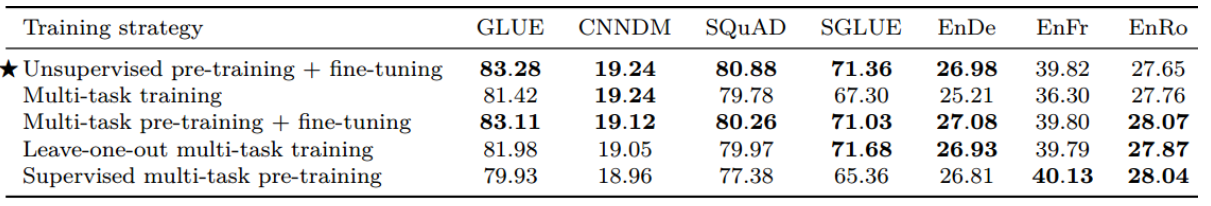   
说明： 多任务预训练+微调 的方式可以取得于baseline近似的结果。这表明多任务学习之后，再进行微调确实有助于缓解不同混合比例之间的一些权衡。另外，抛弃一个任务(“leave-one-out”)的训练结果仅仅轻微下降，说明模型在多个任务上训练确实可以应用于新的任务上。多任务预训练可能不会导致剧烈的任务干扰。

#### 算力分配：
* 角度：模型的规模、训练的时长规模 和 batch size
* 例:假如有4倍的算力，怎么来分配？可以有以下方案：
  * 训练得久些，原来的4倍
  * 每个batch size 扩大为原来4倍
  * 模型扩大2倍，训练时长扩大2倍
  * 模型扩大4倍

##### 实验结果：
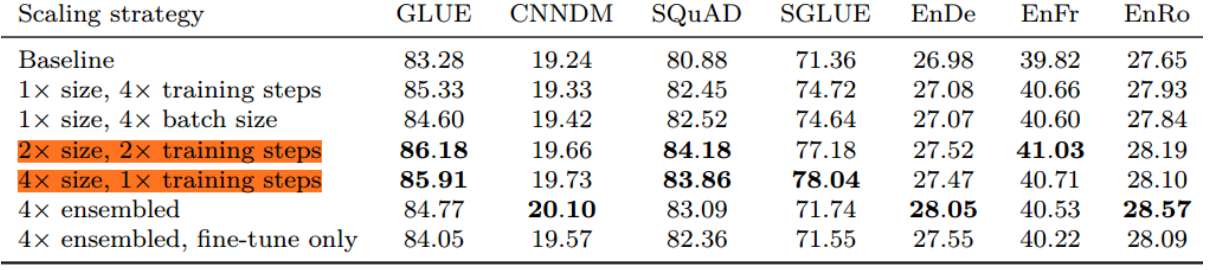







### 展望：
* 不再依赖大模型
  
* 更高效获取知识

* 量pre-training和下游任务相似性的方法
  
* 与语言无关的模型，不受单语言局限性影响